In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
import numpy as np
from pennylane import numpy as qnp
from matplotlib.gridspec import GridSpec

from qmlbo import spectrum, models, signals

### Generate data for Figure 4

In [3]:
n_0 = 7 # size of the signal band
SIGMA_SQ = 0.2
SIGMA = np.sqrt(SIGMA_SQ)
POWER = 0.6
n_fixed = 11
SIGNAL_FOURIER_COEFFICIENTS = np.sqrt(POWER) * np.array([0, 1/np.sqrt(2), 0, 0, 0, 1/np.sqrt(2), 0])

def signal(times, sigma):
    return signals.signal_from_fourier_coefficients(times, fcoeffs=SIGNAL_FOURIER_COEFFICIENTS, sigma=sigma)

# Run an "experiment" with `n` time samples
time_samples = np.linspace(0, 1-1/n_fixed, n_fixed) # this gives dx = 1/n. i.e. x = (0, 1/n, ..., (n-1)/n)
M = 90
timesteps = M * n_fixed
time_continuous = np.linspace(0, 1, timesteps)
noiseless_f_sampled = signal(time_samples, sigma=0) # noiseless samples

In [4]:
# pick the quantum models
MODELS = [
    # initialized model, color, marker, 
    (models.Hamming, 'r', '^',),
    (models.Binary, 'g', 'o',),
    (models.Ternary, 'b', 's'),
    (models.OptimalGolomb, 'm', 'x', ),
]

# CHANGE THIS FOR NICER PLOT ERROR BARS
ntrials = 20
max_qubits = 10
qubits_arr = np.arange(2, max_qubits, 1) # different numbers of cohorts to use

# Gather experimental and analyitical error terms for the model
# first dimension is indexed as 0=bias^2, 1=var, 2=total
ana_errors = np.zeros((len(MODELS), 2, len(qubits_arr)))


for p, (MODEL, _, _) in enumerate(MODELS):
    for j, n_qubits in enumerate(qubits_arr) :
        
        # Set the model and get its weights
        model = MODEL(n=n_qubits)
        if model.name == "Golomb" and n_qubits > 4:
            continue

        spec = spectrum.get_frequency_spectrum(model.lambdas)
        freqs = sorted(spec.keys())
        weights = np.sqrt(np.array([model.degeneracy(k) for k in freqs])) / model.d

        # analytical error is independent of random noise
        bias2, var = signals.compute_bias2_var(noiseless_f_sampled, weights, SIGMA)
        ana_errors[p,0,j] = bias2
        ana_errors[p,1,j] = var

### Plot Figure 4

Hamming
Binary
Ternary
Golomb


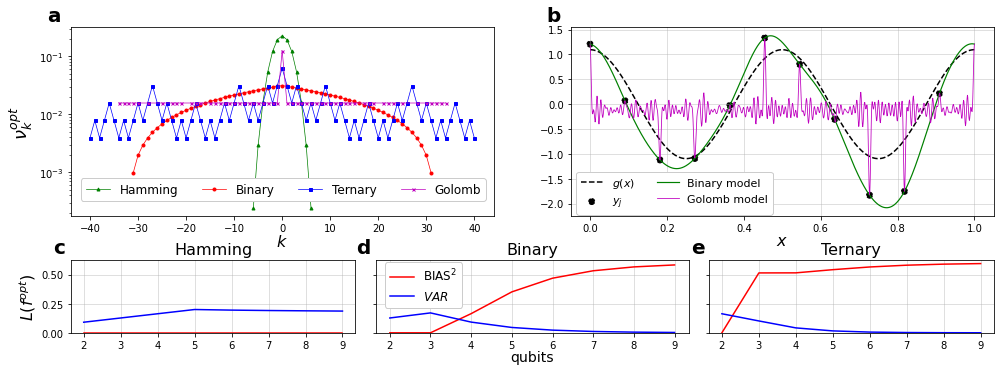

In [7]:
ylab_size = 16
fig = plt.figure(figsize=(14, 5))
gs = GridSpec(3, 6, figure=fig)
ax0 = fig.add_subplot(gs[0:2,:3])
ax1 = fig.add_subplot(gs[0:2,3:])

ax2 = fig.add_subplot(gs[2,0:2])
ax3 = fig.add_subplot(gs[2,2:4], sharey=ax2)
plt.setp(ax3.get_yticklabels(), visible=False)
ax4 = fig.add_subplot(gs[2,4:], sharey=ax2)
plt.setp(ax4.get_yticklabels(), visible=False)

# Panel a: plot the model R(k)'s
sim_package = [
    # initialized model, color, marker, 
    (models.Hamming(n=6), 'g', '^',),
    (models.Binary(n=5), 'r', 'o',),
    (models.Ternary(n=4), 'b', 's'),
    (models.OptimalGolomb(n=3), 'm', 'x', ),
]
for i, package in enumerate(sim_package):
    h_model, color, marker = package
    spec_h = spectrum.get_frequency_spectrum(h_model.lambdas)
    freqs = sorted(spec_h.keys())
    degens = np.array([h_model.degeneracy(k) for k in freqs]) / h_model.d ** 2
    ax0.plot(freqs, degens, c=color, marker=marker, markersize=3, label=h_model.name, lw=0.7)

ax0.semilogy()
ax0.legend(loc="lower left", bbox_to_anchor=(0.01, 0.05), ncol=4, prop={'size': 12}, framealpha=1)  
ax0.set_xlabel(r"$k$", size=16, labelpad=0)
ax0.set_ylabel(r"$\nu_k^{opt}$", size=18)

# Panel b: run a few sample models and show how a model exchanges spikiness for bias
demo_models = [models.Binary(d=8), models.OptimalGolomb(d=16)]
demo_styles = [('g', 1.2), ('m', 0.8)]
np.random.seed(4545) # for plot reproducibility
noisy_samples = signal(time_samples, sigma=SIGMA)
noiseless_signal = signal(time_continuous, sigma=0)
ax1.plot(time_continuous, noiseless_signal, c='k', ls='--', label=r"$g(x)$")
ax1.scatter(time_samples, noisy_samples, c='k', ls='--', label=r"$y_j$")

for kk, model in enumerate(demo_models):
    c, lw = demo_styles[kk]
    f_opt_signal  = models.opt_circuit_model(time_continuous, model, noisy_samples, n_qubits=model.n)
    ax1.plot(time_continuous, f_opt_signal, c=c, label=model.name + " model", lw=lw)

ax1.grid(alpha=0.5)
ax1.set_xlabel(r"$x$", size=16, labelpad=0)
ax1.legend(loc="lower left", bbox_to_anchor=(0, -0.02), framealpha=1, ncol=2, prop={'size': 11})

# Panels c-e plot bias/variance curves for each model, across qubit counts
err_axes = [ax2, ax3, ax4]
for p, (MODEL, _, _) in enumerate(MODELS):
    name = MODEL(n=1).name
    print(name)
    stop = len(qubits_arr)
    if name == "Golomb":
        continue
    err_axes[p].plot(qubits_arr[:stop], ana_errors[p, 0,:stop], c='r', label=r"BIAS$^2$")
    err_axes[p].plot(qubits_arr[:stop], ana_errors[p, 1,:stop], c='b', label=r"$VAR$")

for ax in err_axes:
    ax.set_ylim(0, )
    ax.grid(alpha=0.5)

ax3.set_xlabel("qubits", size=14, labelpad=0)
ax2.set_ylabel(r"$L(f^{opt})$", size=ylab_size)
ax3.legend(loc="upper left", bbox_to_anchor=(0.01, 1.05), framealpha=1, prop={'size': 12})


fig.tight_layout()

# Stretch out the axes a bit to get rid of ugly whitespace
x_delta = 0.01

pos2 = ax2.get_position()
pos3 = ax3.get_position()
pos4 = ax4.get_position()

points2 = pos2.get_points() #  [[x0, y0], [x1, y1]],
points3 = pos3.get_points()
points4 = pos4.get_points()

x0r = points2[1,0]
x1l = points3[0,0]

mid01 = x0r + (x1l - x0r) / 2
x1r = points3[1,0]
x2l = points4[0,0]
mid12 = x1r + (x2l - x1r) / 2

points2[1,0] = mid01 - x_delta
points3[0,0] = mid01 + x_delta
points3[1,0] = mid12 - x_delta
points4[0,0] = mid12 + x_delta

pos2.set_points(points2)
pos3.set_points(points3)
pos4.set_points(points4)

ax2.set_position(pos2)
ax3.set_position(pos3)
ax4.set_position(pos4)

cap_sz = 20
xshift = -0.04
yshift = 1.06
ax0.text(xshift, yshift, r"a", horizontalalignment='center', 
             verticalalignment='center', size=cap_sz, transform=ax0.transAxes, weight="bold")
ax1.text(xshift, yshift, r"b", horizontalalignment='center', 
             verticalalignment='center', size=cap_sz, transform=ax1.transAxes, weight="bold")
ax2.text(xshift, yshift*1.1, r"c", horizontalalignment='center', 
             verticalalignment='center', size=cap_sz, transform=ax2.transAxes, weight="bold")
ax3.text(xshift, yshift*1.1, r"d", horizontalalignment='center', 
             verticalalignment='center', size=cap_sz, transform=ax3.transAxes, weight="bold")
ax4.text(xshift, yshift*1.1, r"e", horizontalalignment='center', 
             verticalalignment='center', size=cap_sz, transform=ax4.transAxes, weight="bold")

ax2.set_title("Hamming", size=16)
ax3.set_title("Binary", size=16)
ax4.set_title("Ternary", size=16)
fig.savefig("../figures/figure4.pdf", bbox_inches="tight")